In [7]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [8]:
get.scale <- function(scaled) {
  if ("scaled:center" %in% names(attributes(scaled))) {
      center <- attr(scaled, "scaled:center")
  } else {
      center <- rep(0, ncol(scaled))
  }
  if ("scaled:scale" %in% names(attributes(scaled))) {
      list(center, attr(scaled, "scaled:scale"))
  } else {
      list(center, rep(1., length(center)))
  }
}
scale.as.x <- function(x, scaled) {
  s <- get.scale(scaled)
  centered <- sweep(x, 2, s[[1]])
  sweep(centered, 2, s[[2]], FUN = "/")
}

scale.as.y <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}

unscale.y <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}

In [9]:
library(ggplot2)
library(lattice)

#Preperation of data as done in the Exploration

#searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#attache Intensity as factor
x$Intensity <- as.numeric(train.data$Intensity) -1

#Output variable
y <- train.data$VALENCE.PLEASANTNESS

#Data without predictors with a correlation index above 0.95
library(caret)

corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.9)  # removes all indices of features which have a correlation of 0.90 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]  #Data frame with only uncorrelated data

## Neuronal Network: Crossvalidation for layer parameters

In [5]:
library(keras)
library(dplyr) 
use_condaenv('r-tensorflow')

fit.and.evaluate <- function(fold, units.1 = 50, units.2 = 50, units.3 = 1, rate.1 = 0.5, rate.2 = 0.5, seed = 100){
    use_session_with_seed(seed, quiet = TRUE)
    
    #split into training and validation set
    val <- assessment(fold)
    train <- analysis(fold)
    
    len <- dim(train)[2]
    train.x <- train[,-len]
    train.y <- train[,len]
    val.x <- val[, -len]
    val.y <- val[,len]
    
    #remove predictor with zero variance in the training set
    idx.zero.var <- apply(train.x, 2, var) == 0
    train.x <- train.x[,!idx.zero.var]
    val.x <- val.x[,!idx.zero.var]
    
    #scaling
    train.x <- scale(train.x, center = T, scale = T)
    val.x <- scale.as.x(val.x,train.x)
    
    #Neuronal network
    nn <- keras_model_sequential()
    nn <- nn %>%
      layer_dense(units = units.1, activation = 'relu', input_shape = c(dim(train.x)[2]),
                  kernel_regularizer = regularizer_l2(l = 0.01)) %>%
      layer_dropout(rate= rate.1)%>%
      layer_dense(units = units.2, activation = 'relu') %>%
      layer_dropout(rate = rate.2)%>%
      layer_dense(units = units.3, activation = 'linear')

    
    nn %>% compile(optimizer = "adam", loss = "mean_squared_error", metrics = list("mean_absolute_error"))
    
    history <- nn %>% fit(
      train.x, train.y, 
      epochs = 30, batch_size = 128, 
      validation_split = 0)
    
    #Prediction
    nn.pred <- predict(nn, as.matrix(val.x))
    #cat(nn.pred)
    sqrt(mean((nn.pred - val.y)^2))
}




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [10]:
library(tidymodels)
set.seed(100)


#full data
full.data <- x
full.data$VALENCE.PLEASANTNESS <- y

#cleaned data (correlation index < 0.95)
corr.data <- corr.x
corr.data$VALENCE.PLEASANTNESS <- y

full.validation_data <- vfold_cv(full.data, v = 5)
corr.validation_data <- vfold_cv(corr.data, v = 5)

#parameters
rate.1 <- seq(0.1,0.9, 0.01)
rate.2 <- seq(0.1,0.9, 0.01)
units.1 <- seq.int(30,80)
units.2 <- seq.int(30,80)
units.3 <- seq.int(1,50)
seeds <- seq.int(100,120)

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──
✔ broom     0.7.2      ✔ rsample   0.0.8 
✔ dials     0.0.9      ✔ tibble    3.0.4 
✔ infer     0.5.3      ✔ tidyr     1.1.2 
✔ modeldata 0.1.0      ✔ tune      0.1.2 
✔ parsnip   0.1.4      ✔ workflows 0.2.1 
✔ purrr     0.3.4      ✔ yardstick 0.0.7 
✔ recipes   0.1.15     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard()         masks scales::discard()
✖ dplyr::filter()          masks stats::filter()
✖ yardstick::get_weights() masks keras::get_weights()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::lift()            masks caret::lift()
✖ yardstick::precision()   masks caret::precision()
✖ yardstick::recall()      masks caret::recall()
✖ yardstick::sensitivity() masks caret::sensitivity()
✖ yardstick::specificity() masks caret::specificity()
✖ recipes::step()          masks stats::step()


In [8]:
full.errors <- c()
corr.errors <- c()

#Iteration of rate.1
for (i in rate.1){     
    full.errors <- rbind(full.errors, sapply(full.validation_data$splits, fit.and.evaluate, rate.1 = i))
    corr.errors <- rbind(corr.errors, sapply(corr.validation_data$splits, fit.and.evaluate, rate.1 = i))
}

In [9]:
full.mean <- rowMeans(full.errors)
corr.mean <- rowMeans(corr.errors)

Saving 6.67 x 6.67 in image



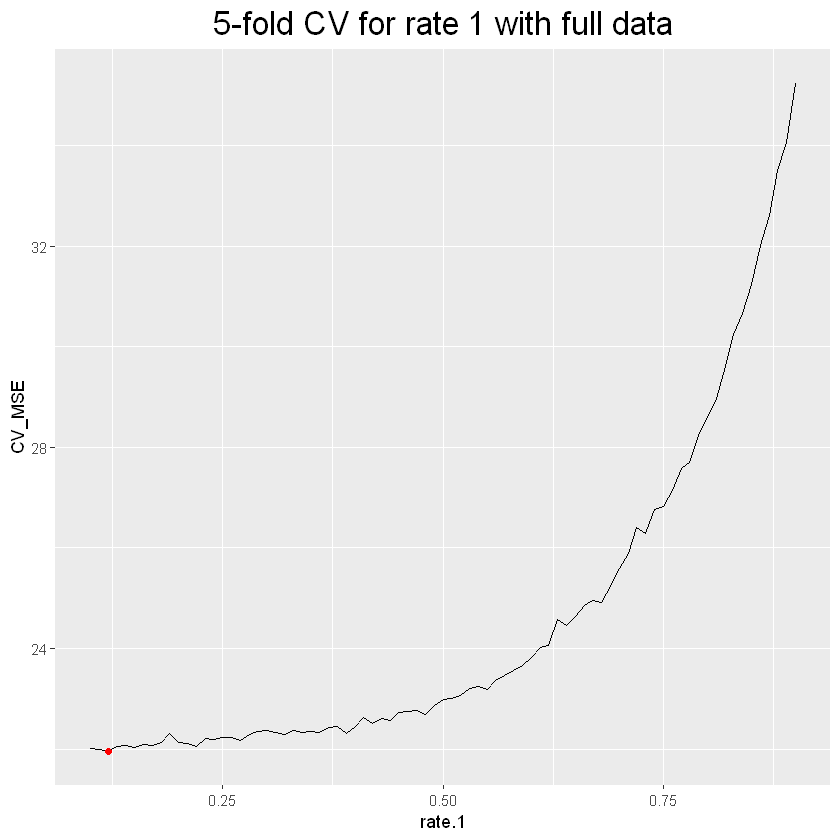

Saving 6.67 x 6.67 in image



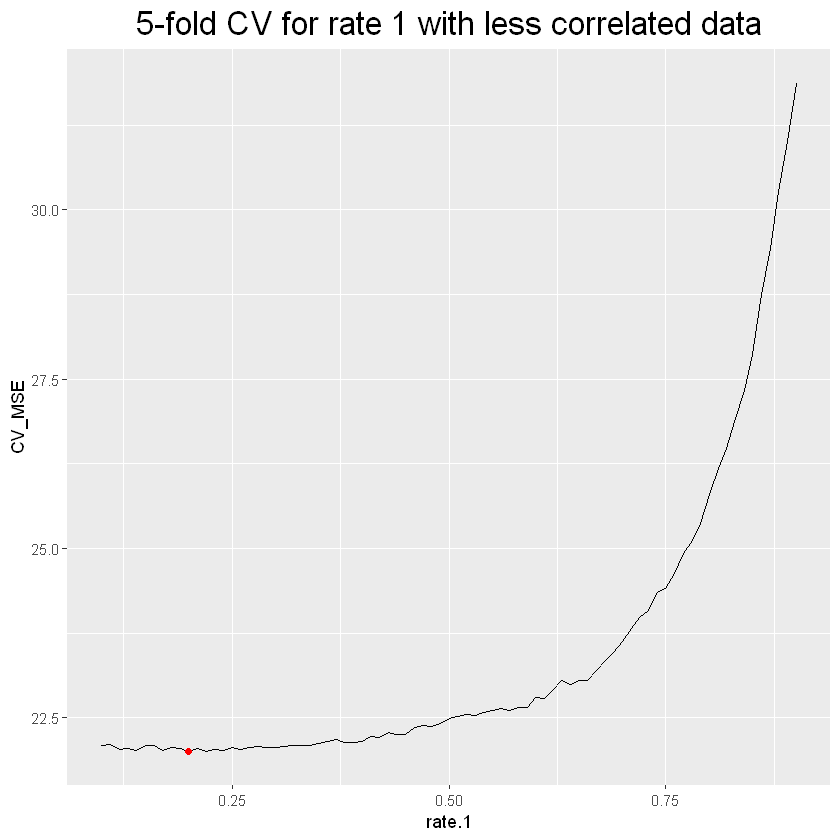

In [10]:
full.min <- which.min(full.mean)
corr.min <- which.min(corr.mean)

full.r1.min <- rate.1[full.min]
corr.r1.min <- rate.1[corr.min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("rate.1" = rate.1, "CV_MSE" = full.mean)
full.data %>% ggplot(aes(x = rate.1, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for rate 1 with full data") + 
geom_point(aes(full.r1.min, full.mean[full.min]), col = "red")
ggsave("../Pictures/rate1_full.png")

corr.data <- data.frame("rate.1" = rate.1, "CV_MSE" = corr.mean)
corr.data %>% ggplot(aes(x = rate.1, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for rate 1 with less correlated data") + 
geom_point(aes(corr.r1.min, corr.mean[corr.min]), col = "red")
ggsave("../Pictures/rate1_corr.png")

In [11]:
full.errors <- c()
corr.errors <- c()

#Iteration of rate.2
for (i in rate.2){     
    full.errors <- rbind(full.errors, sapply(full.validation_data$splits, fit.and.evaluate, rate.1 = full.r1.min, rate.2 = i))
    corr.errors <- rbind(corr.errors, sapply(corr.validation_data$splits, fit.and.evaluate, rate.1 = corr.r1.min, rate.2 = i))
}

In [12]:
full.mean <- rowMeans(full.errors)
corr.mean <- rowMeans(corr.errors)

Saving 6.67 x 6.67 in image



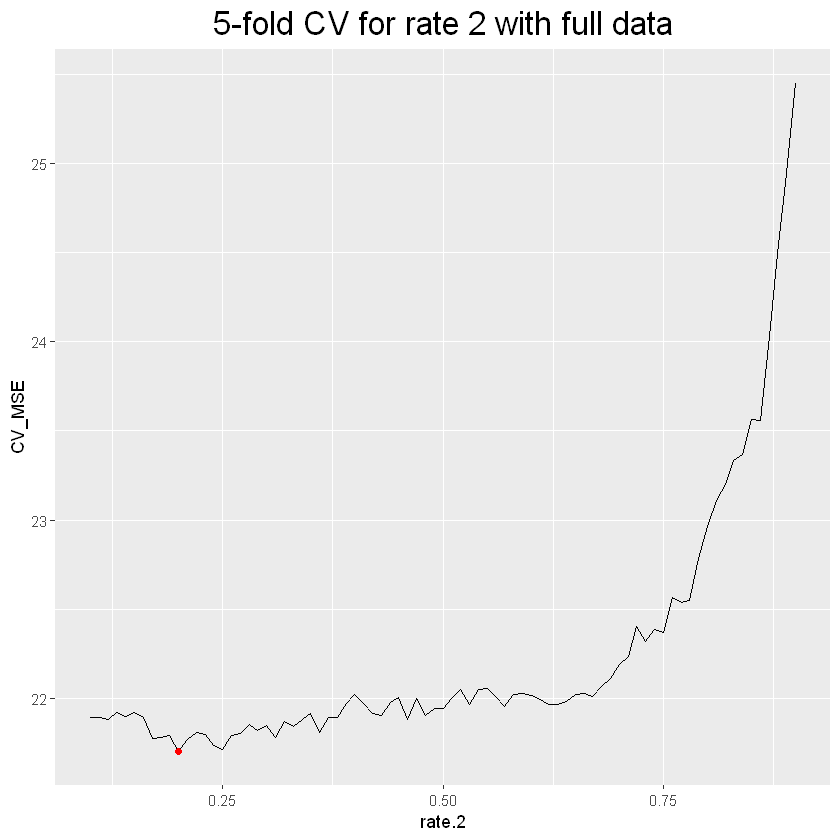

Saving 6.67 x 6.67 in image



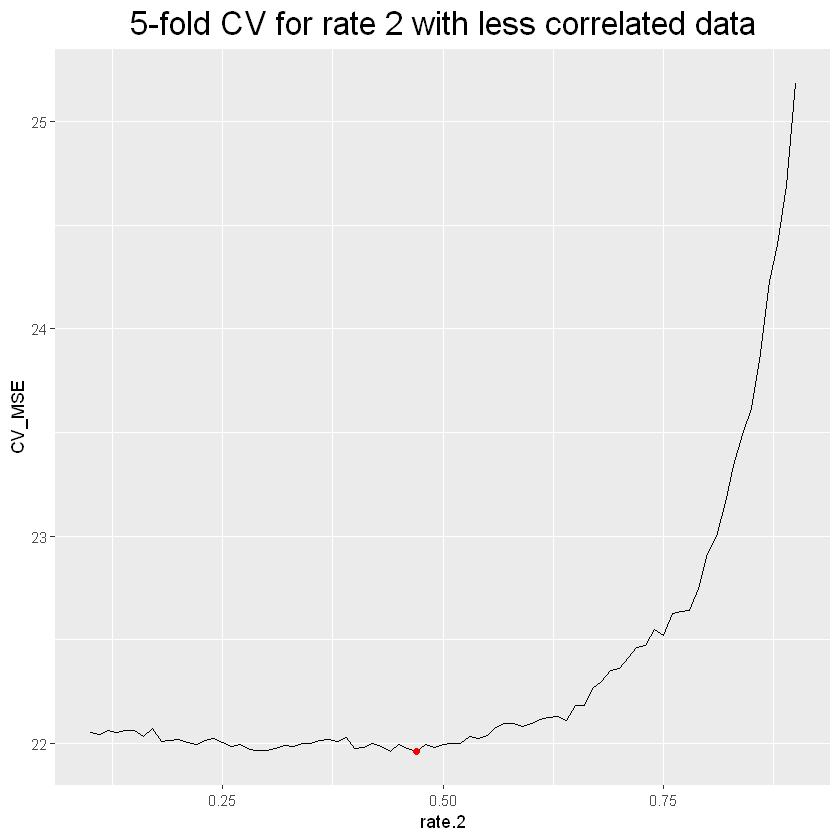

In [13]:
full.min <- which.min(full.mean)
corr.min <- which.min(corr.mean)

full.r2.min <- rate.2[full.min]
corr.r2.min <- rate.2[corr.min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("rate.2" = rate.2, "CV_MSE" = full.mean)
full.data %>% ggplot(aes(x = rate.2, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for rate 2 with full data") + 
geom_point(aes(full.r2.min, full.mean[full.min]), col = "red")
ggsave("../Pictures/rate2_full.png")

corr.data <- data.frame("rate.2" = rate.2, "CV_MSE" = corr.mean)
corr.data %>% ggplot(aes(x = rate.2, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for rate 2 with less correlated data") + 
geom_point(aes(corr.r2.min, corr.mean[corr.min]), col = "red")
ggsave("../Pictures/rate2_corr.png")

In [14]:
full.errors <- c()
corr.errors <- c()

#Iteration of units.1
for (i in units.1){     
    full.errors <- rbind(full.errors, sapply(full.validation_data$splits, fit.and.evaluate, rate.1 = full.r1.min, rate.2 = full.r2.min, units.1 = i))
    corr.errors <- rbind(corr.errors, sapply(corr.validation_data$splits, fit.and.evaluate, rate.1 = corr.r1.min, rate.2 = corr.r2.min, units.1 = i))
}

In [15]:
full.mean <- rowMeans(full.errors)
corr.mean <- rowMeans(corr.errors)

Saving 6.67 x 6.67 in image



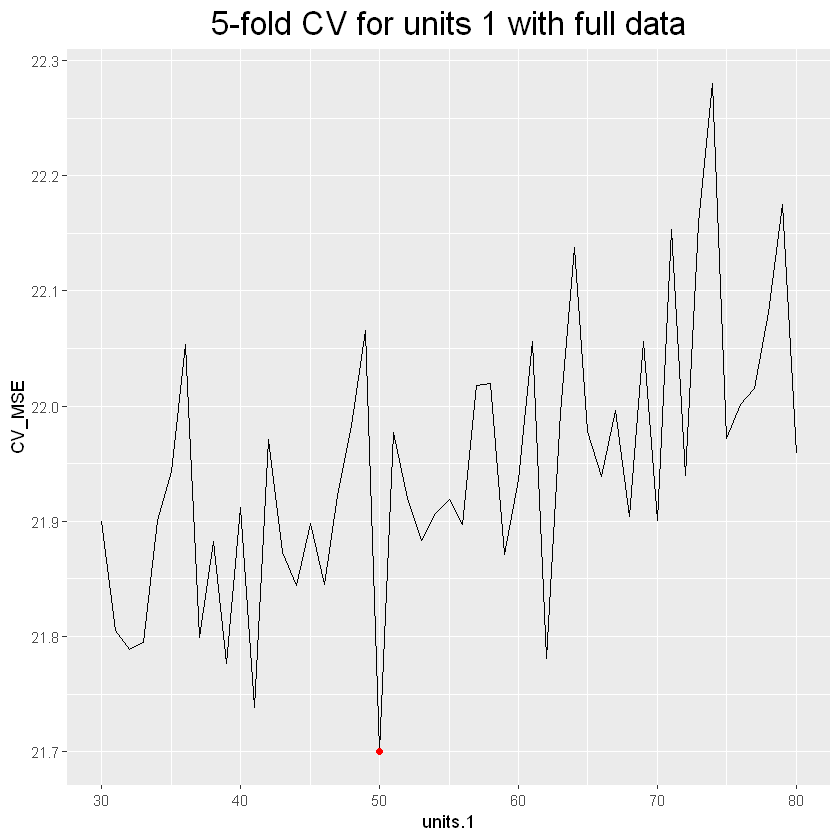

Saving 6.67 x 6.67 in image



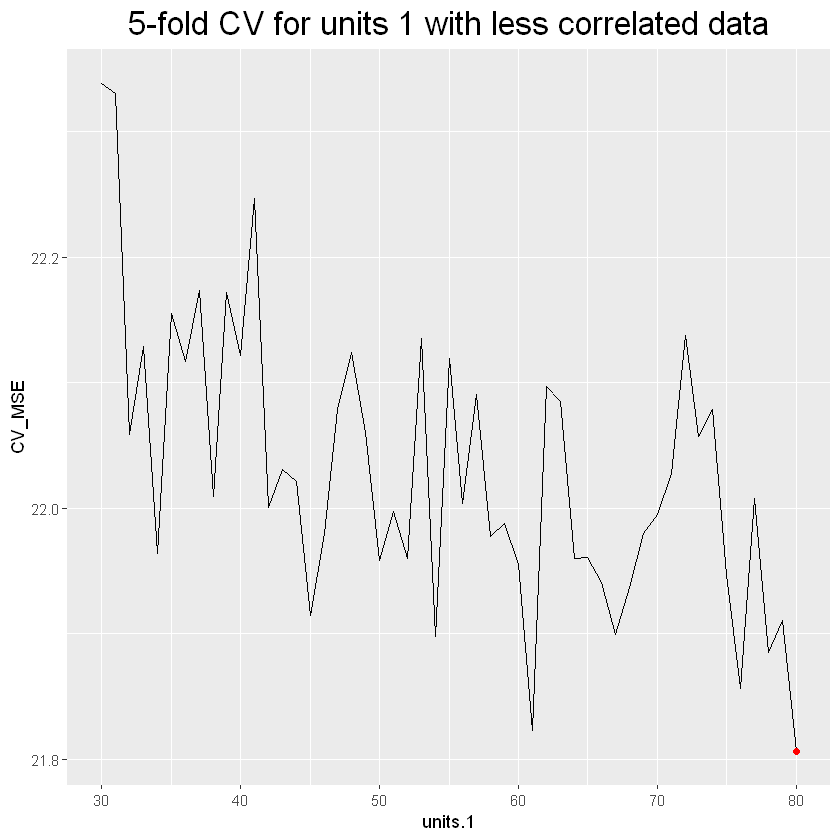

In [16]:
full.min <- which.min(full.mean)
corr.min <- which.min(corr.mean)

full.u1.min <- units.1[full.min]
corr.u1.min <- units.1[corr.min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("units.1" = units.1, "CV_MSE" = full.mean)
full.data %>% ggplot(aes(x = units.1, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for units 1 with full data") + 
geom_point(aes(full.u1.min, full.mean[full.min]), col = "red")
ggsave("../Pictures/units1_full.png")

corr.data <- data.frame("units.1" = units.1, "CV_MSE" = corr.mean)
corr.data %>% ggplot(aes(x = units.1, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for units 1 with less correlated data") + 
geom_point(aes(corr.u1.min, corr.mean[corr.min]), col = "red")
ggsave("../Pictures/units1_corr.png")

In [17]:
full.errors <- c()
corr.errors <- c()

#Iteration of units.2
for (i in units.2){     
    full.errors <- rbind(full.errors, sapply(full.validation_data$splits, fit.and.evaluate, rate.1 = full.r1.min, rate.2 = full.r2.min, units.1 = full.u1.min, units.2 = i))
    corr.errors <- rbind(corr.errors, sapply(corr.validation_data$splits, fit.and.evaluate, rate.1 = corr.r1.min, rate.2 = corr.r2.min, units.1 = corr.u1.min, units.2 = i))
}

In [18]:
full.mean <- rowMeans(full.errors)
corr.mean <- rowMeans(corr.errors)

Saving 6.67 x 6.67 in image



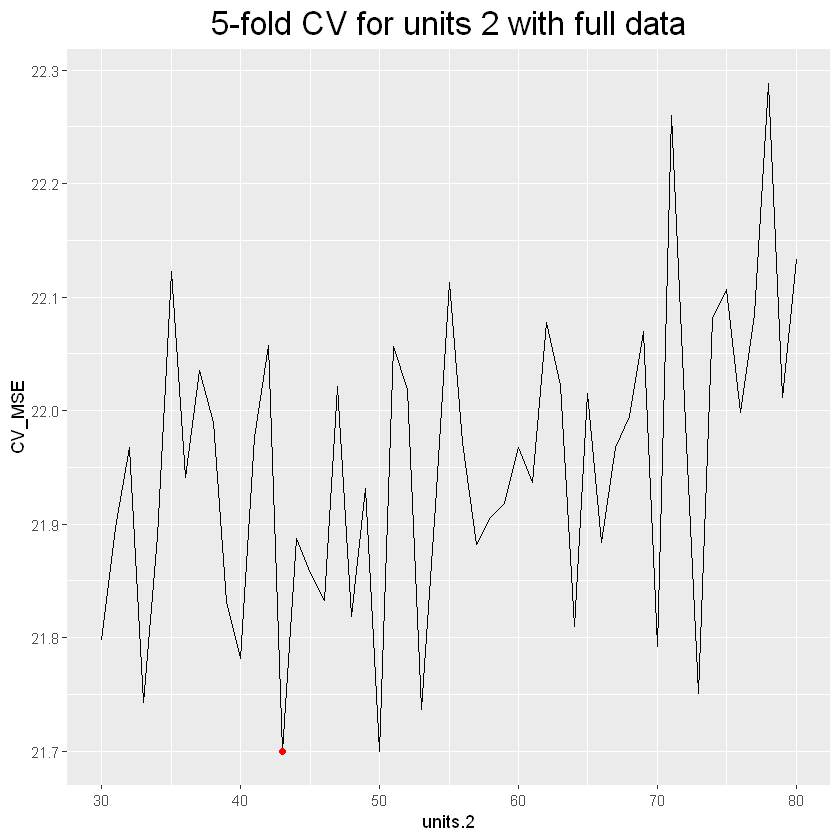

Saving 6.67 x 6.67 in image



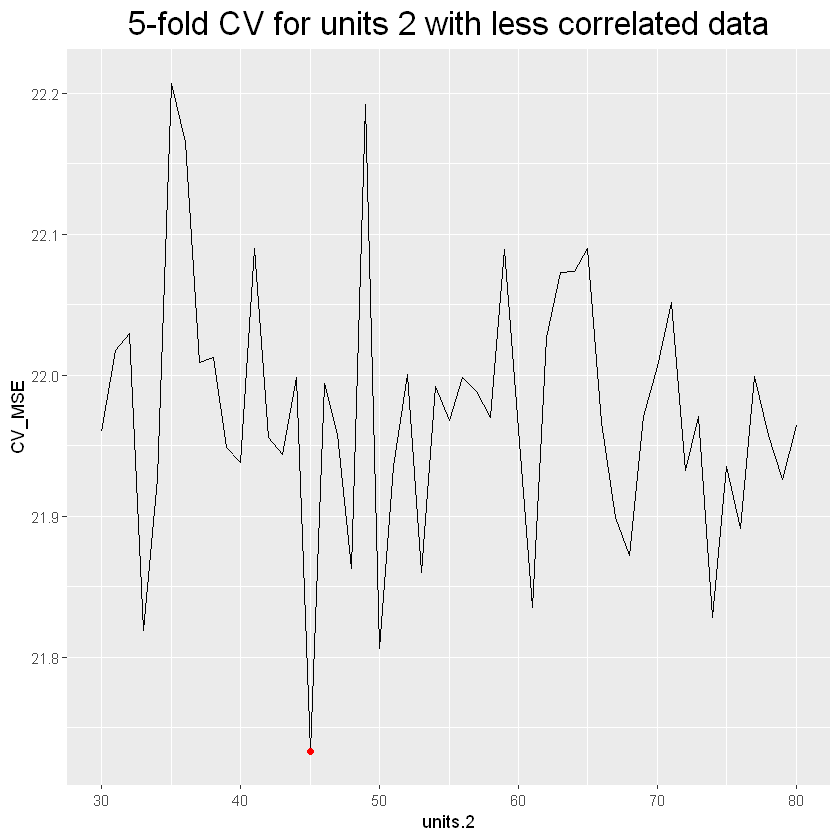

In [19]:
full.min <- which.min(full.mean)
corr.min <- which.min(corr.mean)

full.u2.min <- units.2[full.min]
corr.u2.min <- units.2[corr.min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("units.2" = units.2, "CV_MSE" = full.mean)
full.data %>% ggplot(aes(x = units.2, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for units 2 with full data") + 
geom_point(aes(full.u2.min, full.mean[full.min]), col = "red")
ggsave("../Pictures/units2_full.png")

corr.data <- data.frame("units.2" = units.2, "CV_MSE" = corr.mean)
corr.data %>% ggplot(aes(x = units.2, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for units 2 with less correlated data") + 
geom_point(aes(corr.u2.min, corr.mean[corr.min]), col = "red")
ggsave("../Pictures/units2_corr.png")

In [20]:
full.errors <- c()
corr.errors <- c()

#Iteration of units.3
for (i in units.3){     
    full.errors <- rbind(full.errors, sapply(full.validation_data$splits, fit.and.evaluate, rate.1 = full.r1.min, rate.2 = full.r2.min, units.1 = full.u1.min, units.2 = full.u2.min, units.3 = i))
    corr.errors <- rbind(corr.errors, sapply(corr.validation_data$splits, fit.and.evaluate, rate.1 = corr.r1.min, rate.2 = corr.r2.min, units.1 = corr.u1.min, units.2 = corr.u2.min, units.3 = i))
}

In [21]:
full.mean <- rowMeans(full.errors)
corr.mean <- rowMeans(corr.errors)

Saving 6.67 x 6.67 in image



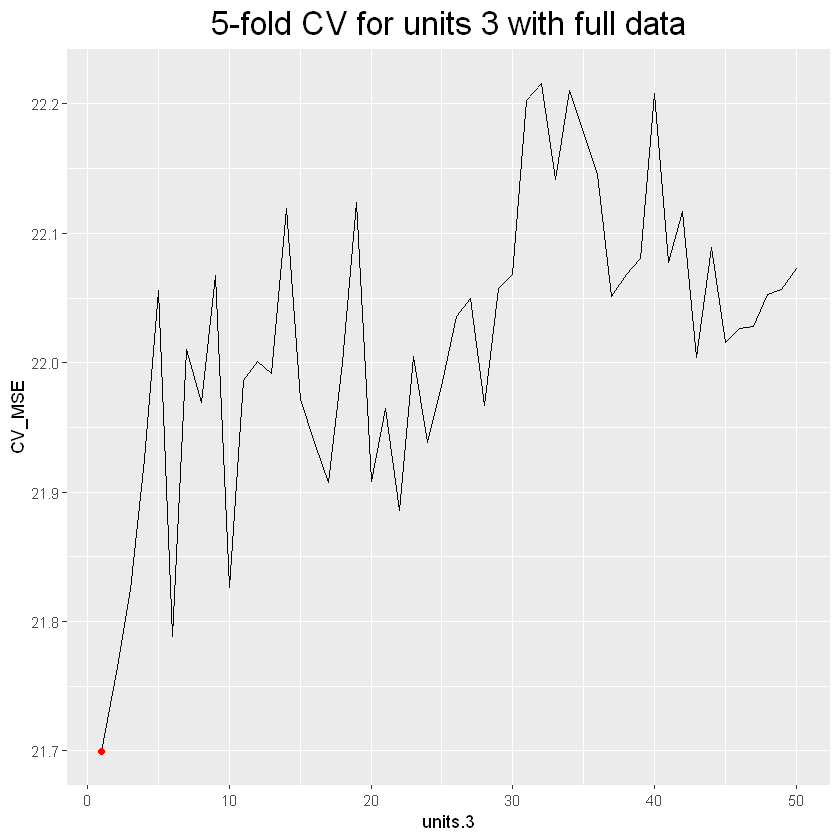

Saving 6.67 x 6.67 in image



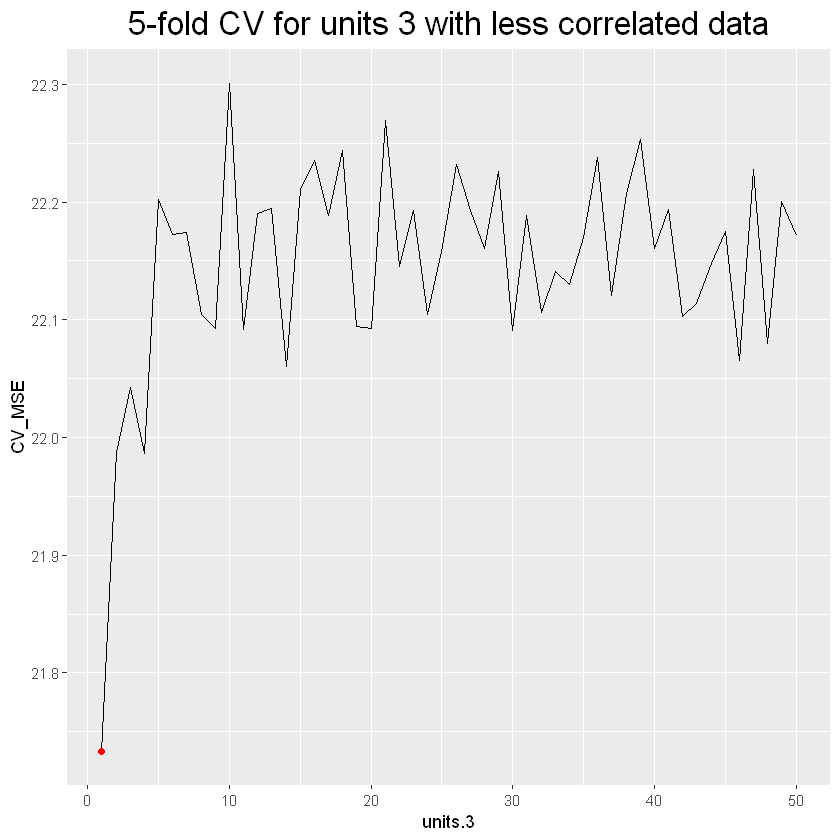

In [22]:
full.min <- which.min(full.mean)
corr.min <- which.min(corr.mean)

full.u3.min <- units.3[full.min]
corr.u3.min <- units.3[corr.min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("units.3" = units.3, "CV_MSE" = full.mean)
full.data %>% ggplot(aes(x = units.3, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for units 3 with full data") + 
geom_point(aes(full.u3.min, full.mean[full.min]), col = "red")
ggsave("../Pictures/units3_full.png")

corr.data <- data.frame("units.3" = units.3, "CV_MSE" = corr.mean)
corr.data %>% ggplot(aes(x = units.3, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for units 3 with less correlated data") + 
geom_point(aes(corr.u3.min, corr.mean[corr.min]), col = "red")
ggsave("../Pictures/units3_corr.png")

In [23]:
full.errors <- c()
corr.errors <- c()

#Iteration of seeds
for (i in seeds){     
    full.errors <- rbind(full.errors, sapply(full.validation_data$splits, fit.and.evaluate, rate.1 = full.r1.min, rate.2 = full.r2.min, units.1 = full.u1.min, units.2 = full.u2.min, units.3 = full.u3.min, seed = i))
    corr.errors <- rbind(corr.errors, sapply(corr.validation_data$splits, fit.and.evaluate, rate.1 = corr.r1.min, rate.2 = corr.r2.min, units.1 = corr.u1.min, units.2 = corr.u2.min, units.3 = corr.u3.min, seed = i))
}

In [24]:
full.mean <- rowMeans(full.errors)
corr.mean <- rowMeans(corr.errors)

Saving 6.67 x 6.67 in image



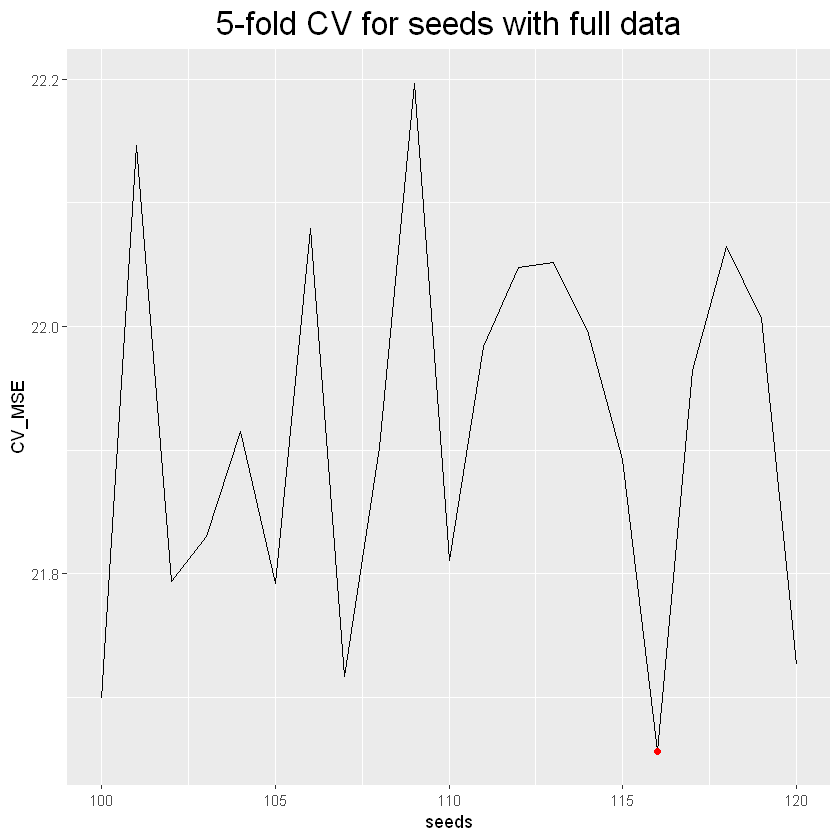

Saving 6.67 x 6.67 in image



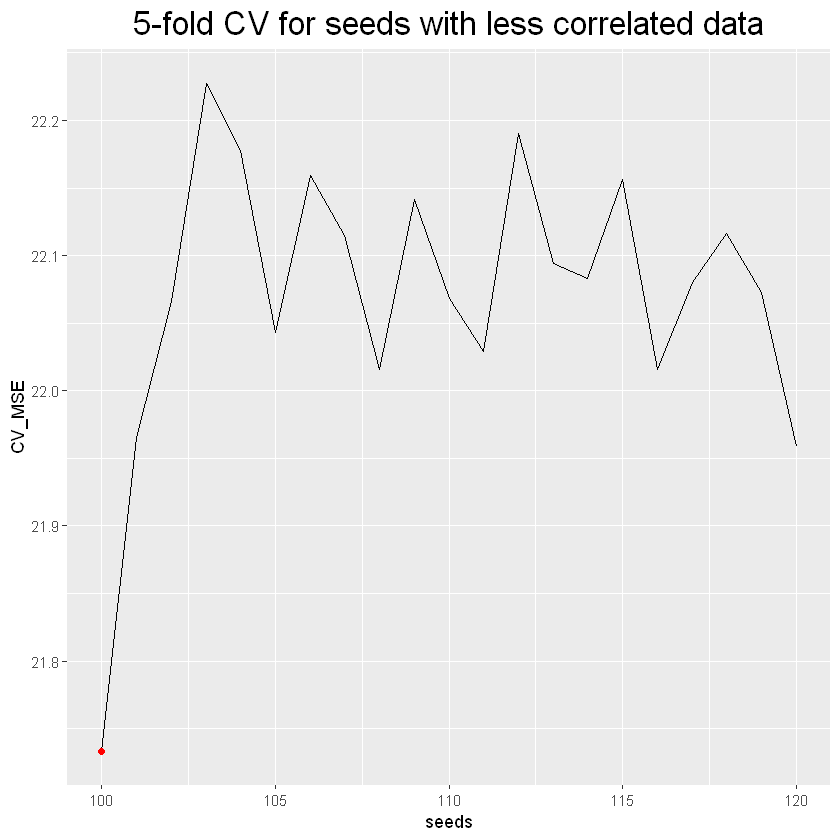

In [27]:
full.min <- which.min(full.mean)
corr.min <- which.min(corr.mean)

full.seeds.min <- seeds[full.min]
corr.seeds.min <- seeds[corr.min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("seeds" = seeds, "CV_MSE" = full.mean)
full.data %>% ggplot(aes(x = seeds, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for seeds with full data") + 
geom_point(aes(full.seeds.min, full.mean[full.min]), col = "red")
ggsave("../Pictures/seeds_full.png")

corr.data <- data.frame("seeds" = seeds, "CV_MSE" = corr.mean)
corr.data %>% ggplot(aes(x = seeds, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for seeds with less correlated data") + 
geom_point(aes(corr.seeds.min, corr.mean[corr.min]), col = "red")
ggsave("../Pictures/seeds_corr.png")

In [28]:
cat("The best parameters for the full data are:", "\n")
cat("rate.1 = ", full.r1.min, " ", "rate.2 = ", full.r2.min, " ", "units.1 = ", 
    full.u1.min , " ", "units.2 = ", full.u2.min, " ", "units.3 = ", full.u3.min, " ", "seed = ", full.seeds.min, "\n")

cat("The best parameters for the  less corrolated data are:", "\n")
cat("rate.1 = ", corr.r1.min, " ", "rate.2 = ", corr.r2.min, " ", "units.1 = ", 
    corr.u1.min , " ", "units.2 = ", corr.u2.min, " ", "units.3 = ", corr.u3.min, " ", "seed = ", corr.seeds.min, "\n")

The best parameters for the full data are: 
rate.1 =  0.12   rate.2 =  0.2   units.1 =  50   units.2 =  43   units.3 =  1   seed =  116 
The best parameters for the  less corrolated data are: 
rate.1 =  0.2   rate.2 =  0.47   units.1 =  80   units.2 =  45   units.3 =  1   seed =  100 


In [30]:
cat("Error with full data: ", full.mean[full.min], "\n")
cat("Error with less correlated data: ", corr.mean[corr.min])

Error with full data:  21.65581 
Error with less correlated data:  21.73277

The results that we obtained with the cleaned data (correlation index < 0.9) is not better. So to impove the parameters in the history function of the neuronal network, we use only the full data.

## Neurnal Network: Cross-Validation for history parameters

In [58]:
units.1.best <- 50
units.2.best <- 43 
units.3.best <- 1
rate.1.best <- 0.12
rate.2.best <- 0.2
seed.best <- 116


fit.and.evaluate.history <- function(fold, units.1 = units.1.best, units.2 = units.2.best, units.3 = units.3.best, rate.1 = rate.1.best, rate.2 = rate.2.best, seed = seed.best, epochs = 30, batch = 128){
    use_session_with_seed(seed, quiet = TRUE)
    
    #split into training and validation set
    val <- assessment(fold)
    train <- analysis(fold)
    
    len <- dim(train)[2]
    train.x <- train[,-len]
    train.y <- train[,len]
    val.x <- val[, -len]
    val.y <- val[,len]
    
    #remove predictor with zero variance in the training set
    idx.zero.var <- apply(train.x, 2, var) == 0
    train.x <- train.x[,!idx.zero.var]
    val.x <- val.x[,!idx.zero.var]
    
    #scaling
    train.x <- scale(train.x, center = T, scale = T)
    val.x <- scale.as.x(val.x,train.x)
    
    #Neuronal network
    nn <- keras_model_sequential()
    nn <- nn %>%
      layer_dense(units = units.1, activation = 'relu', input_shape = c(dim(train.x)[2]),
                  kernel_regularizer = regularizer_l2(l = 0.01)) %>%
      layer_dropout(rate= rate.1)%>%
      layer_dense(units = units.2, activation = 'relu') %>%
      layer_dropout(rate = rate.2)%>%
      layer_dense(units = units.3, activation = 'linear')

    
    nn %>% compile(optimizer = "adam", loss = "mean_squared_error", metrics = list("mean_absolute_error"))
    
    history <- nn %>% fit(
      train.x, train.y, 
      epochs = epochs, batch_size = batch, 
      validation_split = 0)
    
    #Prediction
    nn.pred <- predict(nn, as.matrix(val.x))
    #cat(nn.pred)
    sqrt(mean((nn.pred - val.y)^2))
}

epochs <- seq.int(10,50)
batches <- seq.int(200,240)


In [59]:
errors <- c()
#Iteration of batche_size
for (i in batches){     
    errors <- rbind(errors, sapply(full.validation_data$splits, fit.and.evaluate.history, batch = i))
}

errors.mean <- rowMeans(errors)

Saving 6.67 x 6.67 in image



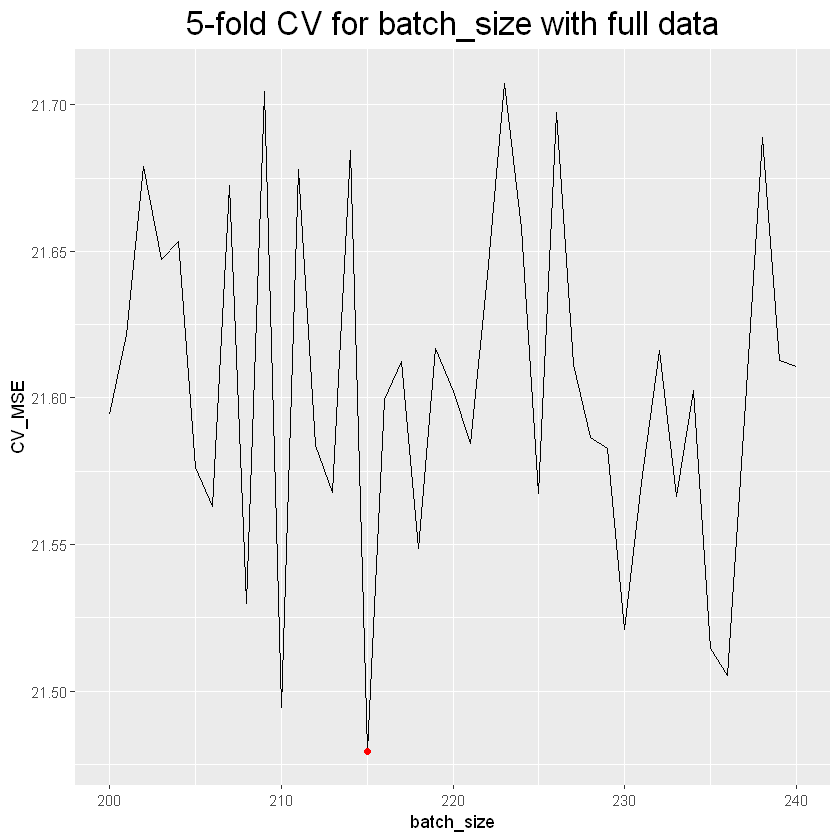

In [60]:
min <- which.min(errors.mean)
batches.min <- batches[min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("batch_size" = batches, "CV_MSE" = errors.mean)
full.data %>% ggplot(aes(x = batch_size, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for batch_size with full data") + 
geom_point(aes(batches.min, errors.mean[min]), col = "red")
ggsave("../Pictures/batches_full.png")

In [61]:
errors <- c()
#Iteration of epochs
for (i in epochs){     
    errors <- rbind(errors, sapply(full.validation_data$splits, fit.and.evaluate.history, epochs = i, batch = batches.min))
}

errors.mean <- rowMeans(errors)

Saving 6.67 x 6.67 in image



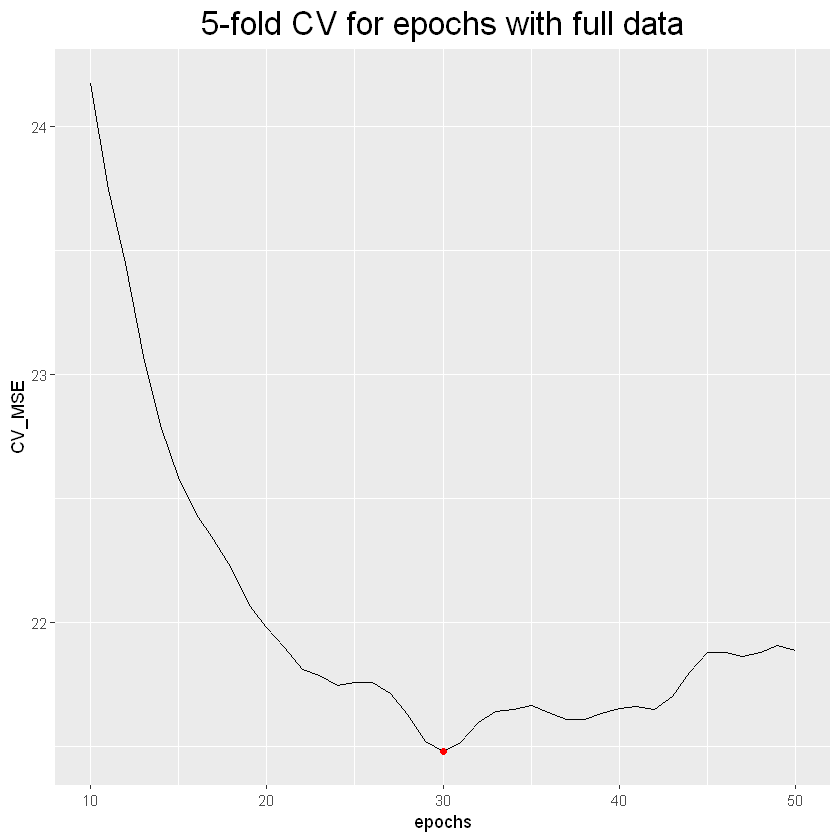

In [64]:
min <- which.min(errors.mean)
epochs.min <- epochs[min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

full.data <- data.frame("epochs" = epochs, "CV_MSE" = errors.mean)
full.data %>% ggplot(aes(x = epochs, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for epochs with full data") + 
geom_point(aes(epochs.min, errors.mean[min]), col = "red")
ggsave("../Pictures/batches_full.png")

In [65]:
cat("The best parameters for the full data are:", "\n")
cat("epoch = ", epochs.min, " ", "batch_size = ", batches.min, "\n")

The best parameters for the full data are: 
epoch =  30   batch_size =  215 


In [66]:
cat("Error with full data: ", errors.mean[min], "\n")

Error with full data:  21.47931 


## Validation

In [21]:
library(keras)
library(dplyr) 
use_condaenv('r-tensorflow')

#Best Parameters
units.1.best <- 50
units.2.best <- 43 
units.3.best <- 1
rate.1.best <- 0.12
rate.2.best <- 0.2
seed.best <- 116
epochs.best <- 30
batch.best <- 215

#Preparation of training and test data

neuronal.net.validation <- function(seed){
    set.seed(seed)
    len <- length(x[,1])
    idx.train <- sample(1:len, 2*len/3)
    train.x <- x[idx.train, ]
    val.x <- x[-idx.train, ]
    
    idx.zero.var <- apply(train.x, 2, var) == 0
    train.x <- train.x[,!idx.zero.var]
    val.x <- val.x[,!idx.zero.var]

    train.x <- scale(train.x, center = T, scale = T)
    val.x <- scale.as.x(val.x,train.x)

    train.y <- y[idx.train]
    val.y <- y[-idx.train]
    
    use_session_with_seed(seed.best, quiet = TRUE)
    nn <- keras_model_sequential()
    nn <- nn %>%
        layer_dense(units = units.1.best, activation = 'relu', input_shape = c(dim(train.x)[2]),
                    kernel_regularizer = regularizer_l2(l = 0.01)) %>%
        layer_dropout(rate= rate.1.best)%>%
        layer_dense(units = units.2.best, activation = 'relu') %>%
        layer_dropout(rate = rate.2.best)%>%
        layer_dense(units = units.3.best, activation = 'linear')


    nn %>% compile(optimizer = "adam", loss = "mean_squared_error", metrics = list("mean_absolute_error"))

    history <- nn %>% fit(
        train.x, train.y, 
        epochs = epochs.best, batch_size = batch.best, 
        validation_split = 0)

    #Prediction
    prediction <- predict(nn, as.matrix(val.x))
    mean((prediction - val.y)^2)
}

seeds <- seq.int(100,150)
MSEs <- sapply(seeds, neuronal.net.validation)
mean.MSE <- mean(sqrt(MSEs))
var <- var(sqrt(MSEs))
cat("The mean RMSE is = ", mean.MSE, " and the variance is = ", var)

The mean RMSE is =  21.99696  and the variance is =  0.8823376

## Submission

In [6]:
library(keras)
library(dplyr) 
#Preparation of training and test data
train.x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(train.x, 2, var) == 0

train.x <- train.x[,!idx.zero.var]
test.x <- test.data[,-c(1,2)]
test.x <- test.x[,!idx.zero.var]

train.x$Intensity <- as.numeric(train.data$Intensity) - 1
test.x$Intensity <- as.numeric(test.data$Intensity) - 1

train.x <- scale(train.x, center = T, scale = T)
test.x <- scale.as.x(test.x,train.x)

train.y <- train.data$VALENCE.PLEASANTNESS
test.y <- test.data$VALENCE.PLEASANTNESS

#Best Parameters
units.1.best <- 50
units.2.best <- 43 
units.3.best <- 1
rate.1.best <- 0.12
rate.2.best <- 0.2
seed.best <- 116
epochs.best <- 30
batch.best <- 215

#Neuronal Network
use_session_with_seed(seed.best, quiet = TRUE)
nn <- keras_model_sequential()
nn <- nn %>%
    layer_dense(units = units.1.best, activation = 'relu', input_shape = c(dim(train.x)[2]),
                kernel_regularizer = regularizer_l2(l = 0.01)) %>%
    layer_dropout(rate= rate.1.best)%>%
    layer_dense(units = units.2.best, activation = 'relu') %>%
    layer_dropout(rate = rate.2.best)%>%
    layer_dense(units = units.3.best, activation = 'linear')

    
nn %>% compile(optimizer = "adam", loss = "mean_squared_error", metrics = list("mean_absolute_error"))
    
history <- nn %>% fit(
    train.x, train.y, 
    epochs = epochs.best, batch_size = batch.best, 
    validation_split = 0)
    
#Prediction
nn.pred <- predict(nn, as.matrix(test.x))



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

